# Individual Dataset preprocessing

Run this using the project image: `quay.io/jbusecke/scale-aware-air-sea:68b654d76dce`

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

- filtering/flux calc performance
    - do single core workers perform better than multi-core ones for filtering?
    - How about the flux calulations?
    - For all the other stuff multi-core workers are much better
- decomp of mean vs mean of decomp
    - open issue comparing the appendix results, and discuss if its worth it.

In [2]:
from scale_aware_air_sea.parameters import get_params
from scale_aware_air_sea.stages import preprocess, test_data_preprocessing
from scale_aware_air_sea.utils import weighted_coarsen, filter_inputs_dataset, to_zarr_split

import numpy as np
import xarray as xr
import gcsfs

In [3]:
# Reproducibility info
import os
os.environ['JUPYTER_IMAGE']

'quay.io/jbusecke/scale-aware-air-sea:3dd162bc47c3'

In [4]:
import dask;print(dask.__version__)

2023.10.0


In [5]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

In [6]:
# write the datasets out to scratch (they are massively large!)
# TODO: I could probably achieve this with some sort of fancy decorator (wrapping some function with the path as input). 
# for now lets just write these bad boys to disk
# load global parameters
params = get_params('v1.0.1', test=False)
models = ['CM26', 'CESM']
full_check=False # run computationally expensive tests

xr.set_options(keep_attrs=True)

In [7]:
import dask
from dask_gateway import Gateway

gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

# options = gateway.cluster_options()
# options.worker_memory = 110 #in anticipation of the new workers.
# options.worker_cores = 14
# display(options)

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# display(cluster)
# client = cluster.get_client()
# # cluster.adapt(1, 100)
# cluster.scale(2)
# client

options = gateway.cluster_options()
# options.worker_memory = 28*3 #in anticipation of the new workers.
# options.worker_cores = 12 
options.worker_memory = 110 #in anticipation of the new workers.
options.worker_cores = 15
# get more mem per worker for the shitty scaling of the flux calc
# Did not get this to work, so back to full utilization and `to_zarr_split`.
display(options)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
display(cluster)
client = cluster.get_client()
cluster.scale(20)
client

[]


/srv/conda/envs/notebook/lib/python3.11/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


<Client: 'tls://10.1.168.86:8786' processes=0 threads=0, memory=0 B>

In [8]:
# from distributed import Client
# client = Client()
# client

In [9]:
# import coiled
# import dask
# cluster = coiled.Cluster(
#     n_workers=10,
#     worker_vm_types= 'n2d-highmem-2',
#     spot_policy='spot_with_fallback',
# )
# cluster.set_keepalive("30 minutes")
# client = cluster.get_client()
# display(cluster)
# client

## Preprocess the model data (write to scratch if does not exist yet)

In [10]:
data_preprocessing = {}
for model in models:
    path = params['paths'][model]['preprocessing']['scratch']
    
    if not fs.exists(path):
        
        print(f'Did not find {path}. Recomputing output')
        ds = preprocess(fs, model)
        
        print(f"Start Writing to zarr {path}")
        cluster.scale(80)
        ds.to_zarr(path)
        cluster.scale(3)
    
    print(f"Reloading data from {path}")
    ds_reloaded = xr.open_dataset(path, engine='zarr', chunks={})
    
    print(f"Testing reloaded data")
    test_data_preprocessing(ds_reloaded, full_check=full_check)
    
    display(ds_reloaded)
    
    data_preprocessing[model] = ds_reloaded

Reloading data from gs://leap-scratch/jbusecke/scale-aware-air-sea/v1.0.1/temp/CM26.zarr
Testing reloaded data


<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolat_t      (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    geolon_t      (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    ice_mask      (time, yt_ocean, xt_ocean) bool dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    NCO:      4.0.3

Reloading data from gs://leap-scratch/jbusecke/scale-aware-air-sea/v1.0.1/temp/CESM.zarr
Testing reloaded data


<xarray.Dataset>
Dimensions:       (yt_ocean: 2400, xt_ocean: 3600, time: 730)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolat_t      (yt_ocean, xt_ocean) float64 nan nan nan nan ... nan nan nan
    geolon_t      (yt_ocean, xt_ocean) float64 nan nan nan nan ... nan nan nan
    ice_mask      (time, yt_ocean, xt_ocean) bool dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
  * time          (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

## Coarsen/Filter the inputs

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def test_smoothed_data(ds_raw, ds, plot=False, full_check=False):
    assert 'smoothing_method' in ds.attrs.keys()
    
    if ds.attrs['smoothing_method'] == 'coarse':
        assert 'n_coarsen' in ds.attrs.keys()
        
        ds_raw = data_preprocessing[model]
        
        # Test that raw and coarse datasets preserver the global mean tracer value
        # This ensures that both the values and the coarsened area are calculated consistently
        test_var = 'surface_temp'
        test_roi = dict(time=slice(0,200))
        # FIXME: THERE IS THIS BIZARRE precision error with weighted again...WTF. Take the `.astype(...)` out to see this mess!!!
        raw_test = ds_raw[test_var].isel(**test_roi).astype(np.float64).weighted(ds_raw.area_t).mean(['xt_ocean', 'yt_ocean']).load()
        test = ds[test_var].isel(**test_roi).astype(np.float64).weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).load()
        if plot:
            plt.figure()
            raw_test.plot(label='raw', ls='-')
            test.plot(label='coarse', ls=':')
            plt.title(f'Global weighted {test_var} average {model}')
            plt.legend()
            plt.show()
        xr.testing.assert_allclose(raw_test, test)
    
    elif ds.attrs['smoothing_method'] == 'filter':
        assert 'filter_type' in ds.attrs.keys()
        assert 'filter_scale' in ds.attrs.keys()

    if full_check:
        # test that there are no all nan maps anywhere
        nan_test = np.isnan(ds).all(['xt_ocean', 'yt_ocean']).to_array().sum()
        assert nan_test.data == 0
      
    ## Tests for all smoothed datasets
    ## are eddies visually eliminated?
    if plot:
        plt.figure()
        ds.isel(time=[0, 100, 300]).surface_temp.plot.contourf(col='time', levels=21, size=4)
        plt.show()

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/smoothing/CM26_coarse_50.zarr


<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    ice_mask      (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
Attributes:
    n_coarsen:         50
    smoothing_method:  coarse

Testing reloaded output


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 37.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


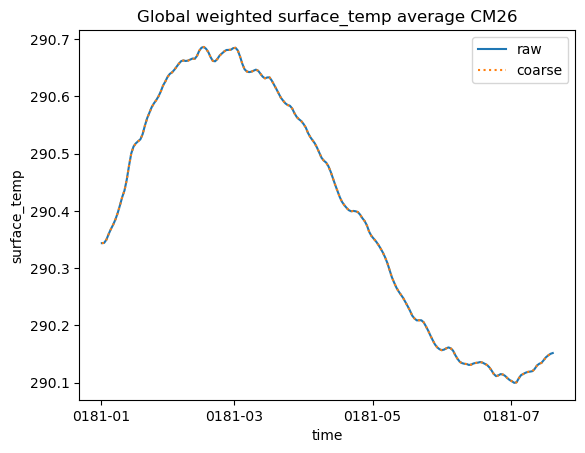

<Figure size 640x480 with 0 Axes>

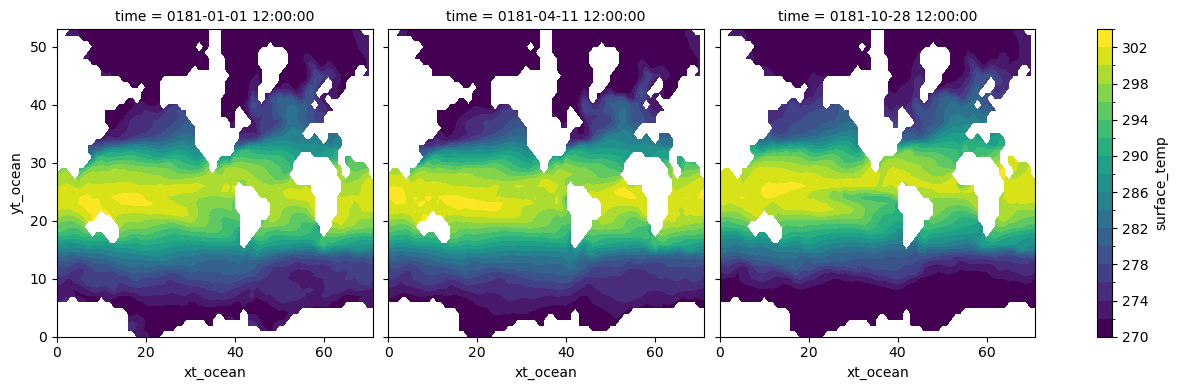

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/smoothing/CESM_coarse_50.zarr


<xarray.Dataset>
Dimensions:       (yt_ocean: 48, xt_ocean: 72, time: 730)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    ice_mask      (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
  * time          (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
Attributes:
    n_coarsen:         50
    smoothing_method:  coarse

Testing reloaded output


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 66.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


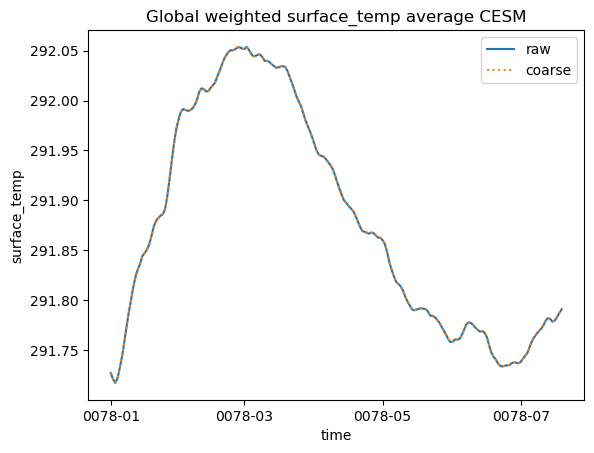

<Figure size 640x480 with 0 Axes>

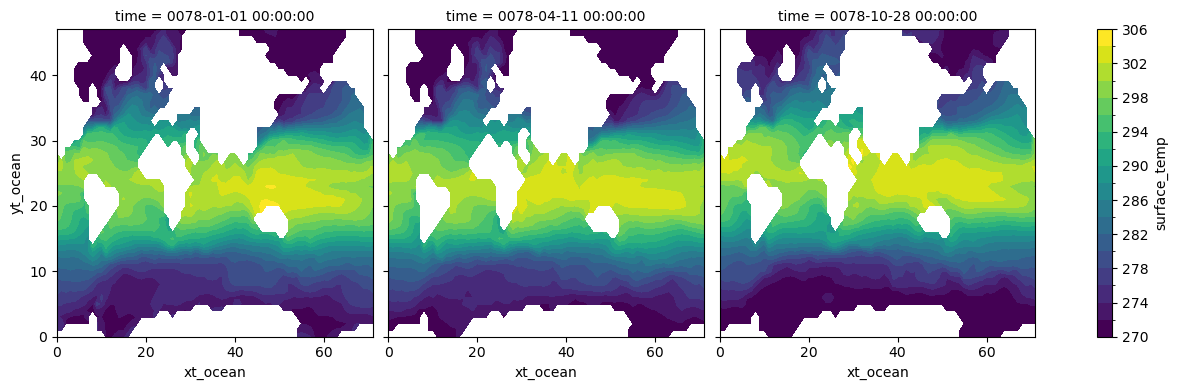

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/smoothing/CM26_filter.zarr


<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    smoothing_method:  filter

Testing reloaded output


<Figure size 640x480 with 0 Axes>

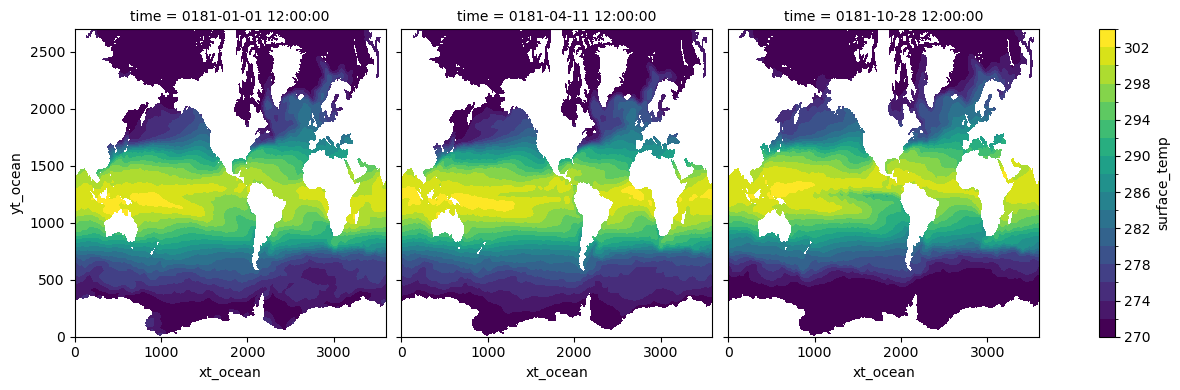

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/smoothing/CESM_filter.zarr


<xarray.Dataset>
Dimensions:       (yt_ocean: 2400, xt_ocean: 3600, time: 730)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
  * time          (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    smoothing_method:  filter

Testing reloaded output


<Figure size 640x480 with 0 Axes>

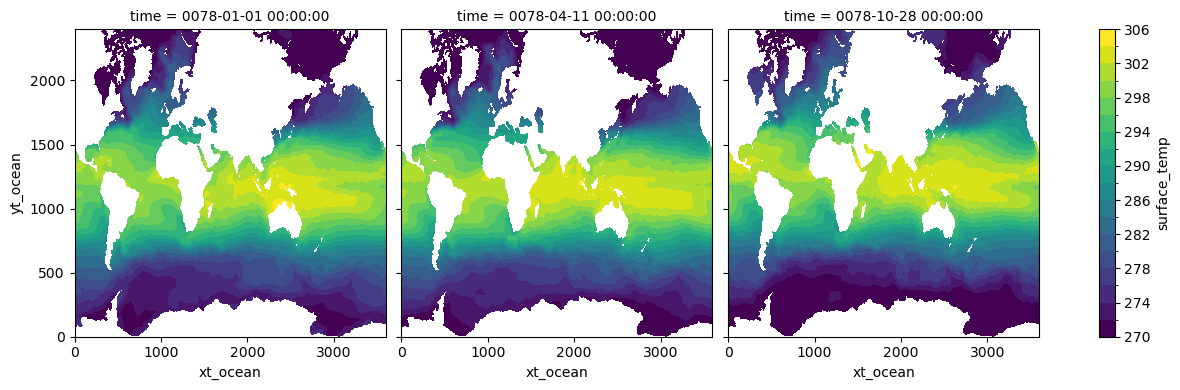

In [12]:
smoothed_data_raw = {'filter':{}, 'coarse':{}}
for smoothing_method in ['coarse', 'filter']:
    for model in models:
        path = params['paths'][model]['smoothing'][smoothing_method]
        if not fs.exists(path):
            print(f'Did not find {path}. Recomputing output')
            ds_in = data_preprocessing[model]
            display(ds_in)

            
            if smoothing_method == 'coarse':
                print(f"Coarsening {model}")
                ds_out = weighted_coarsen(
                    ds_in, 
                    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
                    'area_t'
                )
                ds_out.attrs['n_coarsen'] = params['n_coarsen']
                
            elif smoothing_method == 'filter':
                
                print(f"Filtering {model}")
                
                # the filtering does not like the ice_mask somehow?
                # TODO: debug what is going on here.
                ds_in = ds_in.drop(['ice_mask'])
                # we can always get that back from the original dataset?
                
                ds_out = filter_inputs_dataset(
                    ds_in,
                    ['yt_ocean', 'xt_ocean'], 
                    params['filter_scale'], 
                    filter_type=params['filter_type'],
                )
                ds_out.attrs['filter_type'] = params['filter_type']
                ds_out.attrs['filter_scale'] = params['filter_scale']

            ds_out.attrs['smoothing_method'] = smoothing_method
            display(ds_out)

            print(f"Start Writing to zarr {path} (Size in memory: {ds_out.nbytes/1e12}TB)")
            if smoothing_method=='coarse':
                cluster.scale(100)
            elif smoothing_method=='filter':
                cluster.scale(700)

            ds_out.to_zarr(path)
        print(f"Reloading data from {path}")
        ds_reloaded = xr.open_dataset(path, engine='zarr', chunks={})
        display(ds_reloaded)
        print(f"Testing reloaded output")
        test_smoothed_data(data_preprocessing[model], ds_reloaded, plot=True, full_check=full_check)
        smoothed_data_raw[smoothing_method][model] = ds_reloaded

## Recompute fluxes from 

In [13]:
from aerobulk import noskin
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'surface_temp',
    t_name = 't_ref',
    q_name = 'q_ref',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'slp',
    skin_correction = False
):
    ds = ds.copy() # TODO: Does this help with inplace modification? If so, why?
    # input dependent on method
    # FIXME: Technically we should probably make the 'filtered' suffix optional, since this could also be coarseened?
    if method == 'smooth_tracer':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name]
    elif method == 'smooth_vel_tracer_atmos':
        sst = ds[sst_name]
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered_atmos_only']
        v = ds[v_name+'_filtered_atmos_only']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel_tracer_ocean':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_vel_ocean':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_all':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ## test ranges on first timestep
    noskin(
        sst.isel(time=0),
        t.isel(time=0),
        q.isel(time=0),
        u.isel(time=0),
        v.isel(time=0),
        slp=slp.isel(time=0),
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=True
    )
    
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=False
    )
    return ds_out


def _concat_flux_methods(ds, algo, smoothing_fields, skin_correction):
    algo_datasets = []
    for method in smoothing_fields:
        ds_method = compute_fluxes(ds, algo, method, skin_correction=skin_correction)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)

    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    return ds_algo

def _combine_filtered_unfiltered(ds_unfiltered: xr.Dataset, ds_filtered: xr.Dataset) -> xr.Dataset:
    
    ds_out = ds_unfiltered
    
    filter_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']
     # add the filtered variables to the original dataset
    for var in filter_vars:
        ds_out[var+'_filtered'] = ds_filtered[var]
    
    # Rebuild a second relative wind from only ocean filtered velocities 
    # I think this is easy enough to do on the fly and avoids storing 4 more full fields in the filtered output 
    ds_out['u_relative_filtered_ocean_only'] = ds_out['u_ref'] - ds_out['u_ocean_filtered']
    ds_out['v_relative_filtered_ocean_only'] = ds_out['v_ref'] - ds_out['v_ocean_filtered']

    ds_out['u_relative_filtered_atmos_only'] = ds_out['u_ref_filtered'] - ds_out['u_ocean']
    ds_out['v_relative_filtered_atmos_only'] = ds_out['v_ref_filtered'] - ds_out['v_ocean']
    return ds_out
    

def flux_compute_wrapper_filter(unfiltered:xr.Dataset, filtered:xr.Dataset, algo_options:list[str, bool], smoothing_fields: list[str], ice_mask:xr.DataArray) -> xr.Dataset:
    """Wrapper to apply the flux computation for different algorithms and smoothed fields
    
    """
    # merge filtered variables into unfiltered dataset
    ds = _combine_filtered_unfiltered(unfiltered, filtered)
    
    # calculate fluxes for each specified algo and concat
    datasets = []
    for algo, skin_correction in algo_options:
        ds_algo = _concat_flux_methods(ds, algo, smoothing_fields, skin_correction)
        datasets.append(ds_algo)
    ds_out = xr.concat(datasets, dim='algo')
    
    # mask with ice_mask
    # Ice mask needs to be applied after, because tempo-spatially variable nans lead to problems with the flux calculation
    ds_out = ds_out.where(ice_mask)
    ds_out.attrs = ds_out.attrs | ds_filter.attrs
    return ds_out

# coarsened data needs a totally different wrapper!!!
def flux_compute_wrapper_coarse(coarsened:xr.Dataset, filtered_fluxes:xr.Dataset, coarsen_dim_dict:dict[str:int]) -> xr.Dataset:
    
    datasets = []
    # align both datasets on inner for time
    exclude_dims = set(filtered_fluxes.dims)-set(['time'])
    filtered_fluxes, coarsened  = xr.align(filtered_fluxes, coarsened, join='inner', exclude=exclude_dims)
    
    # make sure the area of the filtered_fluxes array is masked consistently with the variables (needed for `weighted_coarsen`)
    nanmask = np.isnan(filtered_fluxes.qh.isel(time=0).drop('time'))
    area_masked = filtered_fluxes.area_t.where(~nanmask, 0.0)
    filtered_fluxes = filtered_fluxes.assign_coords(area_t=area_masked)
    
    # for this dataset we only have two methods
    # 1. The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
    # This needs to be computed over every algo
    # to avoid misalignment, lets capture the algo from the filtered_fluxes dataset
    # TODO: Once we actually implement the skin_correction, that needs to be somehow extracted from the algo dimension
    # for now hardcode
    skin_correction = False
    iter_algos = filtered_fluxes.algo.data
    # in case there is only a single algo
    filtered_fluxes = filtered_fluxes.squeeze()
    for algo in iter_algos:
        # The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
        ds_coarse_single_algo = compute_fluxes(coarsened, algo, 'smooth_none', skin_correction=skin_correction)
        # FIXME: this naming is not really easy to understand. Basically I am computing the fluxes on the coarsened dataset
        # which is equivalent to the 'smooth_all' in the filtered_fluxes. But for `compare_fluxes` we need to pretend like this is the full res dataset (input 'smooth_none'). 
        # This is obviously a shit design for this function and should be remedied.
        # I could rename the coarsened data before? 
        ds_coarse_single_algo = ds_coarse_single_algo.assign_coords(smoothing='smooth_all')
        datasets.append(ds_coarse_single_algo)
    ds_all_coarse = xr.concat(datasets, dim='algo')
    # and the equivalent to smooth none, where we coarsen the full res flux output
    # this is based on the other precomputed data, so all the algos are there already
    
    # keep only the variables we also have on the filtered_fluxes data
    ds_all_coarse = ds_all_coarse[list(filtered_fluxes.data_vars)]
    
    ds_none_coarse = weighted_coarsen(
        filtered_fluxes.sel(smoothing='smooth_none'), 
        coarsen_dim_dict,
        'area_t'
    )
    ds_none_coarse = ds_none_coarse.assign_coords(smoothing='smooth_none')
    
    # See note about the ice mask above: `ds_none_coarse` actually incorporates the ice mask (because it is applied as part of the flux calculation), and so this dataset has *a*
    # icemask. For now lets just apply this to the final output.
    # TODO: discuss if the coarsening is appropriate for treating the ice mask. currently AFAIK every larger box that has at least a single value in it will show up in the coarsened
    # output, thus e.g. central americas land barrier dissapears.
    ice_mask_coarse = ~np.isnan(ds_none_coarse.ql.reset_coords(drop=True))
    ds_all_coarse = ds_all_coarse.where(ice_mask_coarse)
    ds_all_coarse.coords['ice_mask'] = ice_mask_coarse

    # Finally concat along the 'smoothing' dimension (FIXME: better naming for this would be nice).
    ds_full_coarse = xr.concat([ds_none_coarse, ds_all_coarse], dim='smoothing', compat='override', coords='minimal')
    ds_full_coarse.attrs = ds_full_coarse.attrs | coarsened.attrs
    return ds_full_coarse

In [14]:
def test_data_flux(ds:xr.Dataset, plot=False, full_check=False):
    for attr in ['smoothing_method', 'production_spec', 'model']:
        print(attr)
        assert attr in ds.attrs.keys()

    if ds.attrs['production_spec'] == 'appendix':
        assert len(ds.time) == 365
    elif ds.attrs['production_spec'] == 'prod':
        if ds.attrs['model'] == 'CM26':
            assert len(ds.time) == 7305
        elif ds.attrs['model'] == 'CESM':
            assert len(ds.time) == 730

    # test that there are no all nan maps anywhere
    if full_check:
        nan_test = np.isnan(ds).all(['xt_ocean', 'yt_ocean']).to_array().sum()
        assert nan_test.data == 0

    # Check the ice-mask
    plt.figure()
    ds.qh.isel(time=[0,90, 180], algo=0, smoothing=0).plot(col='time', robust=True)
    plt.show()

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CM26_fluxes_filter_prod.zarr


<xarray.Dataset>
Dimensions:    (algo: 1, yt_ocean: 2700, xt_ocean: 3600, smoothing: 4,
                time: 7305)
Coordinates:
  * algo       (algo) <U5 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   prod
    smoothing_method:  filter

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

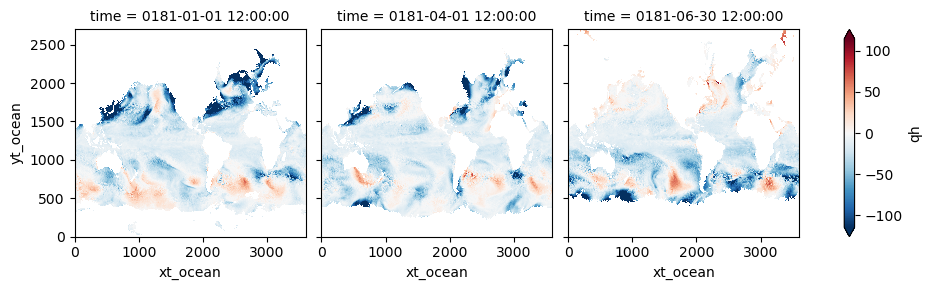

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CESM_fluxes_filter_prod.zarr


<xarray.Dataset>
Dimensions:    (algo: 1, yt_ocean: 2400, xt_ocean: 3600, smoothing: 4, time: 730)
Coordinates:
  * algo       (algo) <U5 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' ... 'smooth_all'
  * time       (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CESM
    production_spec:   prod
    smoothing_method:  filter

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

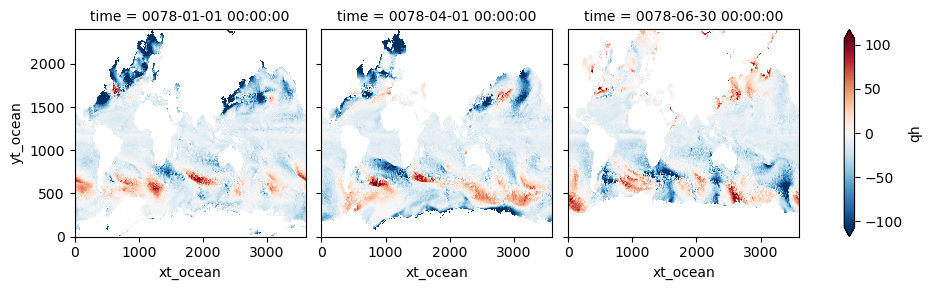

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CM26_fluxes_filter_appendix.zarr


<xarray.Dataset>
Dimensions:    (algo: 5, yt_ocean: 2700, xt_ocean: 3600, smoothing: 6, time: 365)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   appendix
    smoothing_method:  filter

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

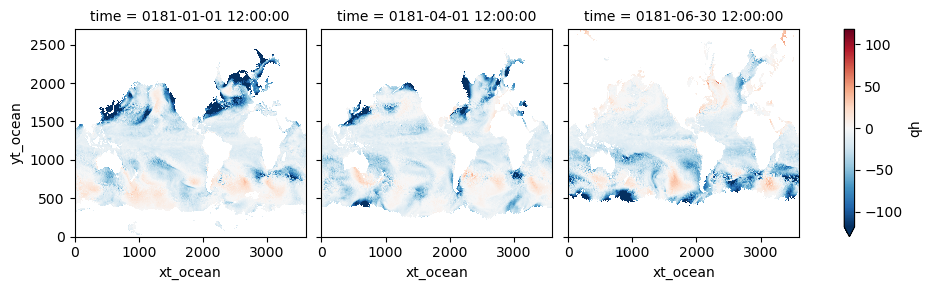

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CM26_fluxes_coarse_50_prod.zarr


<xarray.Dataset>
Dimensions:    (algo: 1, yt_ocean: 54, xt_ocean: 72, smoothing: 2, time: 7305)
Coordinates:
  * algo       (algo) int64 0
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (smoothing, time, yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>
    ql         (smoothing, time, yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>
Attributes:
    model:             CM26
    n_coarsen:         50
    production_spec:   prod
    smoothing_method:  coarse

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

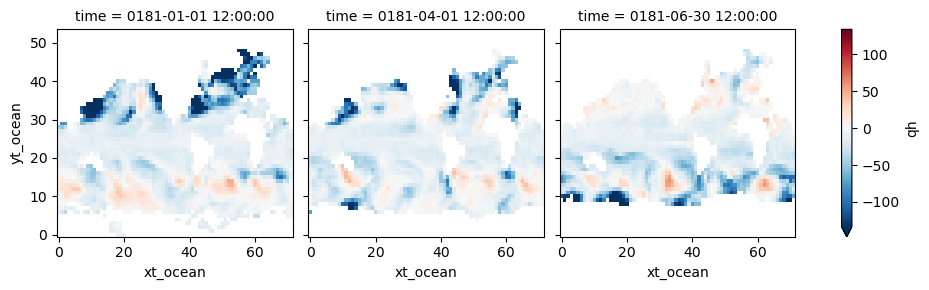

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CESM_fluxes_coarse_50_prod.zarr


<xarray.Dataset>
Dimensions:    (algo: 1, yt_ocean: 48, xt_ocean: 72, smoothing: 2, time: 730)
Coordinates:
  * algo       (algo) int64 0
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 1, 48, 72, 1), meta=np.ndarray>
    ql         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 1, 48, 72, 1), meta=np.ndarray>
Attributes:
    model:             CESM
    n_coarsen:         50
    production_spec:   prod
    smoothing_method:  coarse

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

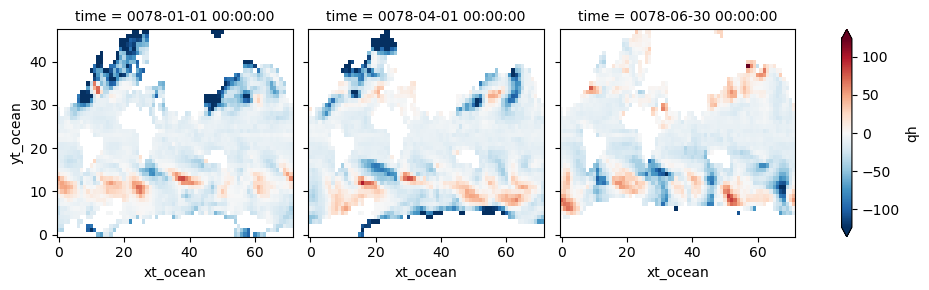

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/fluxes/CM26_fluxes_coarse_50_appendix.zarr


<xarray.Dataset>
Dimensions:    (algo: 5, yt_ocean: 54, xt_ocean: 72, smoothing: 2, time: 365)
Coordinates:
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t     (yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(54, 72, 5), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 51, 51), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 51, 51), meta=np.ndarray>
Attributes:
    model:             CM26
    n_coarsen:         50
    production_spec:   appendix
    smoothing_method:  coarse

Testing reloaded output
smoothing_method
production_spec
model


<Figure size 640x480 with 0 Axes>

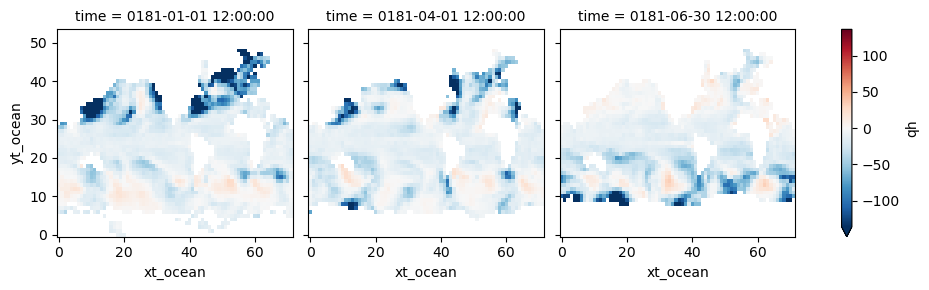

In [15]:
flux_time_slice = {
    'prod': slice(0,None),
    'appendix': slice(0, 365)
}
smoothing_fields = {
    'prod':[
        'smooth_none',
        'smooth_vel_tracer_ocean',
        'smooth_vel_tracer_atmos',
        'smooth_all'
    ],
    'appendix':[
        'smooth_none',
        'smooth_tracer',
        'smooth_vel',
        'smooth_vel_tracer_ocean',
        'smooth_vel_tracer_atmos',
        'smooth_all'
    ],
}
algo_options = {
    'prod':[
        ('ecmwf', False), 
    ],
    'appendix':
    [
        ('ncar', False), 
        ('ecmwf', False), 
        ('coare3p0', False), 
        ('coare3p6', False), 
        ('andreas', False)
    ]
}

flux_data = {'filter':{'prod':{}, 'appendix':{}}, 'coarse':{'prod':{}, 'appendix':{}}}

# CESM_fluxes_filter_appendix fails. I suspect due to some issue with large wind values or similar. 
# Needs debugging, but for now I will only run appendix for CM2.6?

# for smoothing_method in ['filter', 'coarse']:
#     for production_spec in ['prod', 'appendix']:
#         for model in models:
for smoothing_method, production_spec, model in [
    ('filter', 'prod', 'CM26'),
    ('filter', 'prod', 'CESM'),
    ('filter', 'appendix', 'CM26'),
    # # ('filter', 'appendix', 'CESM'), # this one fails
    ('coarse', 'prod', 'CM26'),
    ('coarse', 'prod', 'CESM'),
    ('coarse', 'appendix', 'CM26'),
    # ('coarse', 'appendix', 'CESM'), # cant do this one without the filtered
]:
    path = params['paths'][model]['fluxes'][smoothing_method][production_spec]

    if not fs.exists(path):
        print(f'Did not find {path}. Recomputing output')
        
        ds_unfiltered = data_preprocessing[model].isel(time=flux_time_slice[production_spec])
        ds_filter = smoothed_data_raw['filter'][model].isel(time=flux_time_slice[production_spec])
        ds_coarse = smoothed_data_raw['coarse'][model].isel(time=flux_time_slice[production_spec])
        
        print(f"Computing Fluxes {model} {smoothing_method} {production_spec}")
        if smoothing_method == 'filter':
            ds_out = flux_compute_wrapper_filter(
                ds_unfiltered,
                ds_filter,
                algo_options[production_spec],
                smoothing_fields[production_spec],
                ds_unfiltered['ice_mask'],
            )
        elif smoothing_method == 'coarse':
            # this needs the filtered flux input
            # not a good desing here, since we need to keep the loops in this specific order
            ds_filter_fluxes = flux_data['filter'][production_spec][model]

            ds_out = flux_compute_wrapper_coarse(
                ds_coarse,
                ds_filter_fluxes,
                {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']},
            )
            
            # again, some issue with the ice mask
            ds_out = ds_out.drop(['ice_mask'])

        ds_out.attrs['production_spec'] = production_spec
        ds_out.attrs['model'] = model
        
        # retain only heat fluxes
        ds_out = ds_out[['qh', 'ql']]
        
        # testing: 
        ds_out = ds_out.drop([va for va in ['ice_mask'] if va in ds_out.variables])
        
        display(ds_out)
        
        print(f"Start Writing to zarr {path} (Size in memory: {ds_out.nbytes/1e12}TB)")
        # this somehow still does not work in one go for filtering
        if smoothing_method == 'coarse':
            ds_out.to_zarr(path)
        elif smoothing_method == 'filter':
            split_interval = 30 if production_spec == 'appendix' else 600
            to_zarr_split(ds_out, fs.get_mapper(path), split_interval=split_interval)

    print(f"Reloading data from {path}")
    ds_reloaded = xr.open_dataset(path, engine='zarr', chunks={})
    display(ds_reloaded)
    
    print(f"Testing reloaded output")
    test_data_flux(ds_reloaded, full_check=full_check)
    
    flux_data[smoothing_method][production_spec][model] = ds_reloaded         

## Decompose small scale signals

In [16]:
def small_scale_decomposition(ds: xr.Dataset) -> xr.Dataset:
    """This encodes a lot of the theoretical discussions I had with Dhruv"""
    
    # FIXME: This attribute should be set in the smoothing/coarsening steps.
    method = ds.attrs.get('smoothing_method', None)
    if method is None or method not in ['coarse', 'filter']:
        raise ValueError(
            "Input dataset needs to contain a dataset attribute `smooth_method` indicating ",
            "if the dataset was filtered (value='filter') or coarsened (value='coarse')."
        )
    
    def filt(ds: xr.Dataset) -> xr.Dataset:
        """Utility function to reapply filtering as smoother"""
        return filter_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], params['filter_scale']) # TODO: should I pass the params in a better way? Maybe create a filtering class?
    
    # NOTE: We don't need this for coarsening, because that is a reynolds operator
    
    tdict = {}
    
    # Q_H (AB) - high resolution input
    if method == 'filter':
        tdict['Q_H'] = ds.sel(smoothing='smooth_none')
        tdict['Q_H_bar'] = filt(tdict['Q_H'])
    elif method == 'coarse':
        tdict['Q_H_bar'] = ds.sel(smoothing='smooth_none')
        
    # Q_L low resolution input
    if method == 'filter': 
        tdict['Q_L'] = ds.sel(smoothing='smooth_all')
        tdict['Q_L_bar'] = filt(tdict['Q_L'])
        tdict['Q_L_prime'] = tdict['Q_L'] - tdict['Q_L_bar'] # TODO: I could potentially compute this on the fly...
    elif method == 'coarse':
        tdict['Q_L_bar'] = ds.sel(smoothing='smooth_all')
        
    
    # Inferred Small scale
    if method == 'filter':
        tdict['Q_star'] = tdict['Q_H_bar'] - tdict['Q_L']
        tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
    elif method == 'coarse':
        tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
        
    # mixed low resolution input (filtered only)
    if method == 'filter':
        if 'smooth_vel_tracer_ocean' in ds.smoothing and 'smooth_vel_tracer_atmos' in ds.smoothing:
            tdict['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
            tdict['Q_L_ocean_bar'] = filt(tdict['Q_L_ocean'])

            tdict['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
            tdict['Q_L_atmos_bar'] = filt(tdict['Q_L_atmos'])

            tdict['Q_star_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean_bar']
            tdict['Q_star_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos_bar']

        if 'smooth_vel' in ds.smoothing and 'smooth_tracer' in ds.smoothing:
            tdict['Q_L_vel'] = ds.sel(smoothing='smooth_vel')
            tdict['Q_L_vel_bar'] = filt(tdict['Q_L_vel'])

            tdict['Q_L_tracer'] = ds.sel(smoothing='smooth_tracer')
            tdict['Q_L_tracer_bar'] = filt(tdict['Q_L_tracer'])

            tdict['Q_star_star_vel'] = tdict['Q_H_bar'] - tdict['Q_L_vel_bar']
            tdict['Q_star_star_tracer'] = tdict['Q_H_bar'] - tdict['Q_L_tracer_bar']
    
    # concat into a single dataset
    datasets = [tdict[t].assign_coords(term=t).drop([dvar for dvar in ['smoothing'] if dvar in tdict[t]]) for t in tdict.keys()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out

In [30]:
def test_data_results(ds:xr.Dataset, plot=False, full_check=False):
    for attr in ['smoothing_method', 'production_spec', 'model', 'time_spec']:
        print(attr)
        assert attr in ds.attrs.keys()

    if ds.attrs['time_spec'] == 'native':
        if ds.attrs['production_spec'] == 'appendix':
            assert len(ds.time) == 365
        elif ds.attrs['production_spec'] == 'prod':
            if ds.attrs['model'] == 'CM26':
                assert len(ds.time) == 7305
            elif ds.attrs['model'] == 'CESM':
                assert len(ds.time) == 730

    # test that there are no all nan maps anywhere
    if full_check:
        nan_test = np.isnan(ds).all(['xt_ocean', 'yt_ocean']).to_array().sum()
        assert nan_test.data == 0

    if plot:
        for va in ds.data_vars:
            plt.figure()
            da_plot = ds[va].isel(algo=0)
            if 'time' in da_plot.dims:
                da_plot = da_plot.isel(time=[0,90,180]) # load here to separate loading from plotting issues
                kwargs = dict(col='term', row='time', robust=True)
                
            else:
                kwargs= dict(col='term', robust=True)
            
            da_plot.plot(**kwargs)
            plt.show()

In [31]:
# define dict tree (where I can write into multiple levels
# https://stackoverflow.com/questions/5369723/multi-level-defaultdict-with-variable-depth/8702435#8702435
from collections import defaultdict
nested_dict = lambda: defaultdict(nested_dict)

In [32]:
# cluster.scale(450)

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_filter_decomposed_mean_prod.zarr


<xarray.Dataset>
Dimensions:   (algo: 1, yt_ocean: 2700, xt_ocean: 3600, term: 3)
Coordinates:
  * algo      (algo) <U5 'ecmwf'
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   prod
    smoothing_method:  filter
    time_spec:         prod

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

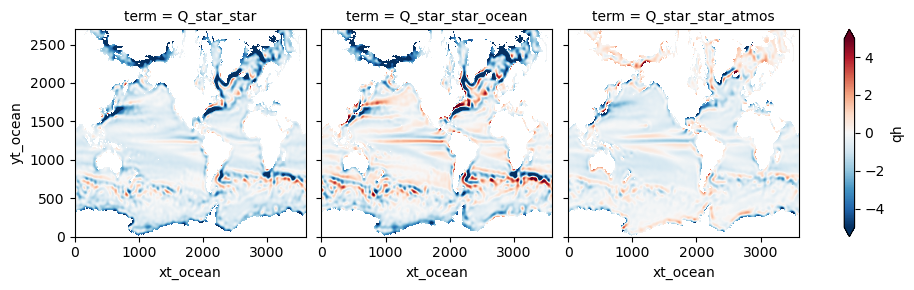

<Figure size 640x480 with 0 Axes>

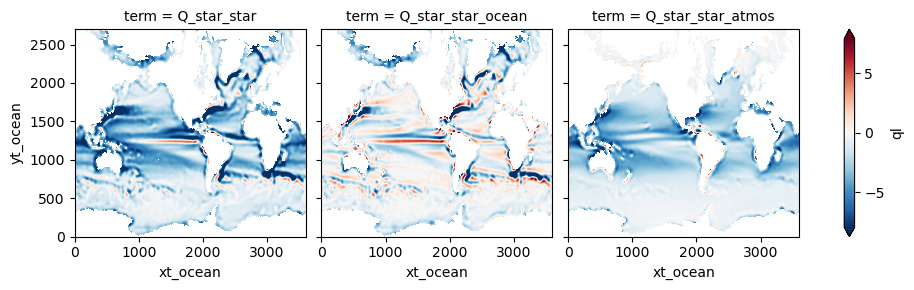

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CESM_fluxes_filter_decomposed_mean_prod.zarr


<xarray.Dataset>
Dimensions:   (algo: 1, yt_ocean: 2400, xt_ocean: 3600, term: 3)
Coordinates:
  * algo      (algo) <U5 'ecmwf'
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(300, 450), meta=np.ndarray>
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    ql        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CESM
    production_spec:   prod
    smoothing_method:  filter
    time_spec:         prod

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

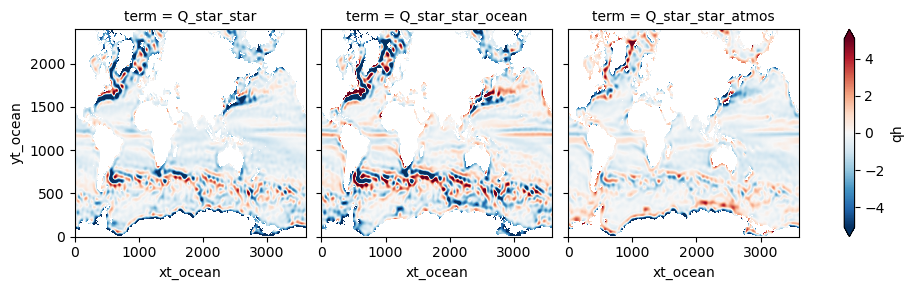

<Figure size 640x480 with 0 Axes>

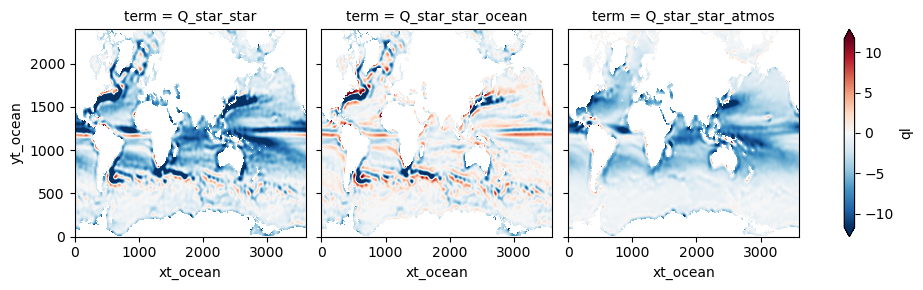

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_filter_decomposed_mean_appendix.zarr


<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 2700, xt_ocean: 3600, term: 6)
Coordinates:
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * term      (term) <U18 'Q_star' 'Q_star_star' ... 'Q_star_star_tracer'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
    ql        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   appendix
    smoothing_method:  filter
    time_spec:         appendix

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

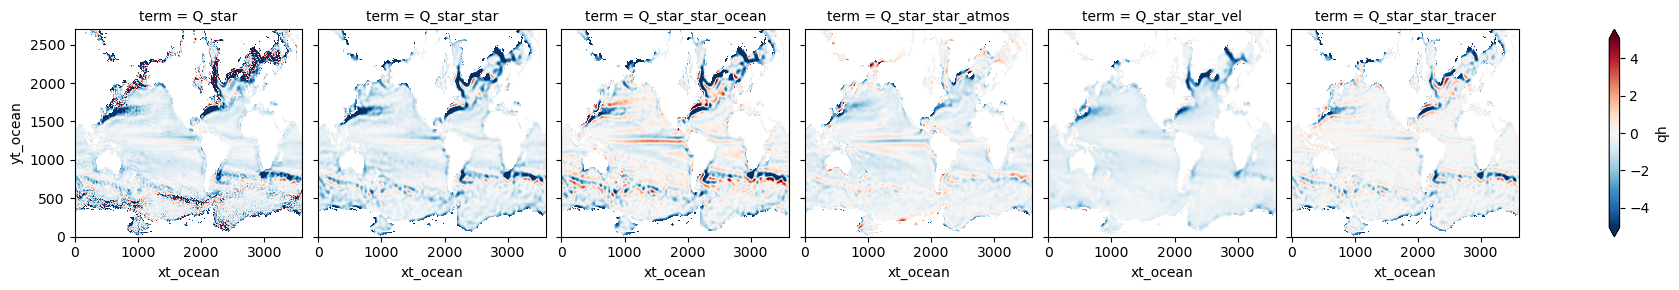

<Figure size 640x480 with 0 Axes>

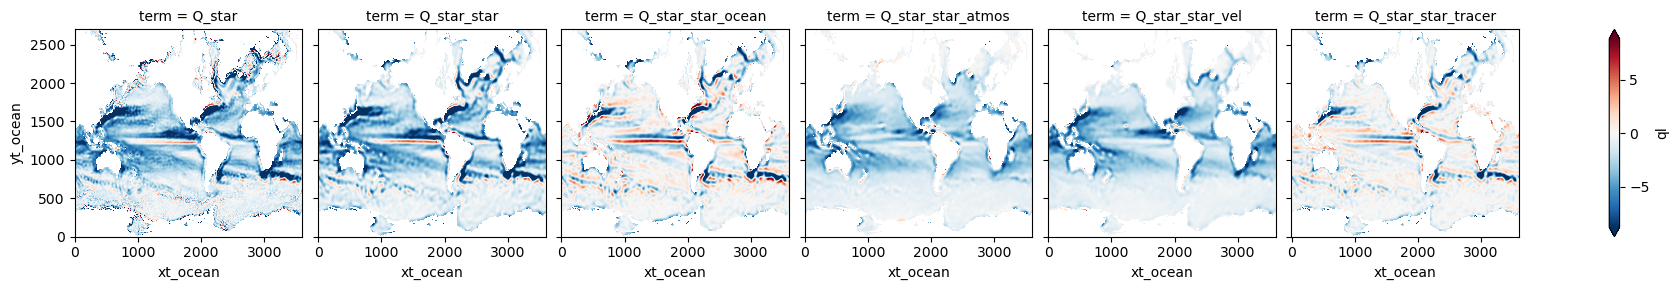

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_filter_decomposed_native_appendix.zarr


<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 2700, xt_ocean: 3600, term: 6, time: 365)
Coordinates:
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * term      (term) <U18 'Q_star' 'Q_star_star' ... 'Q_star_star_tracer'
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:      50
    filter_type:       gaussian
    model:             CM26
    production_spec:   appendix
    smoothing_method:  filter
    time_spec:         appendix

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

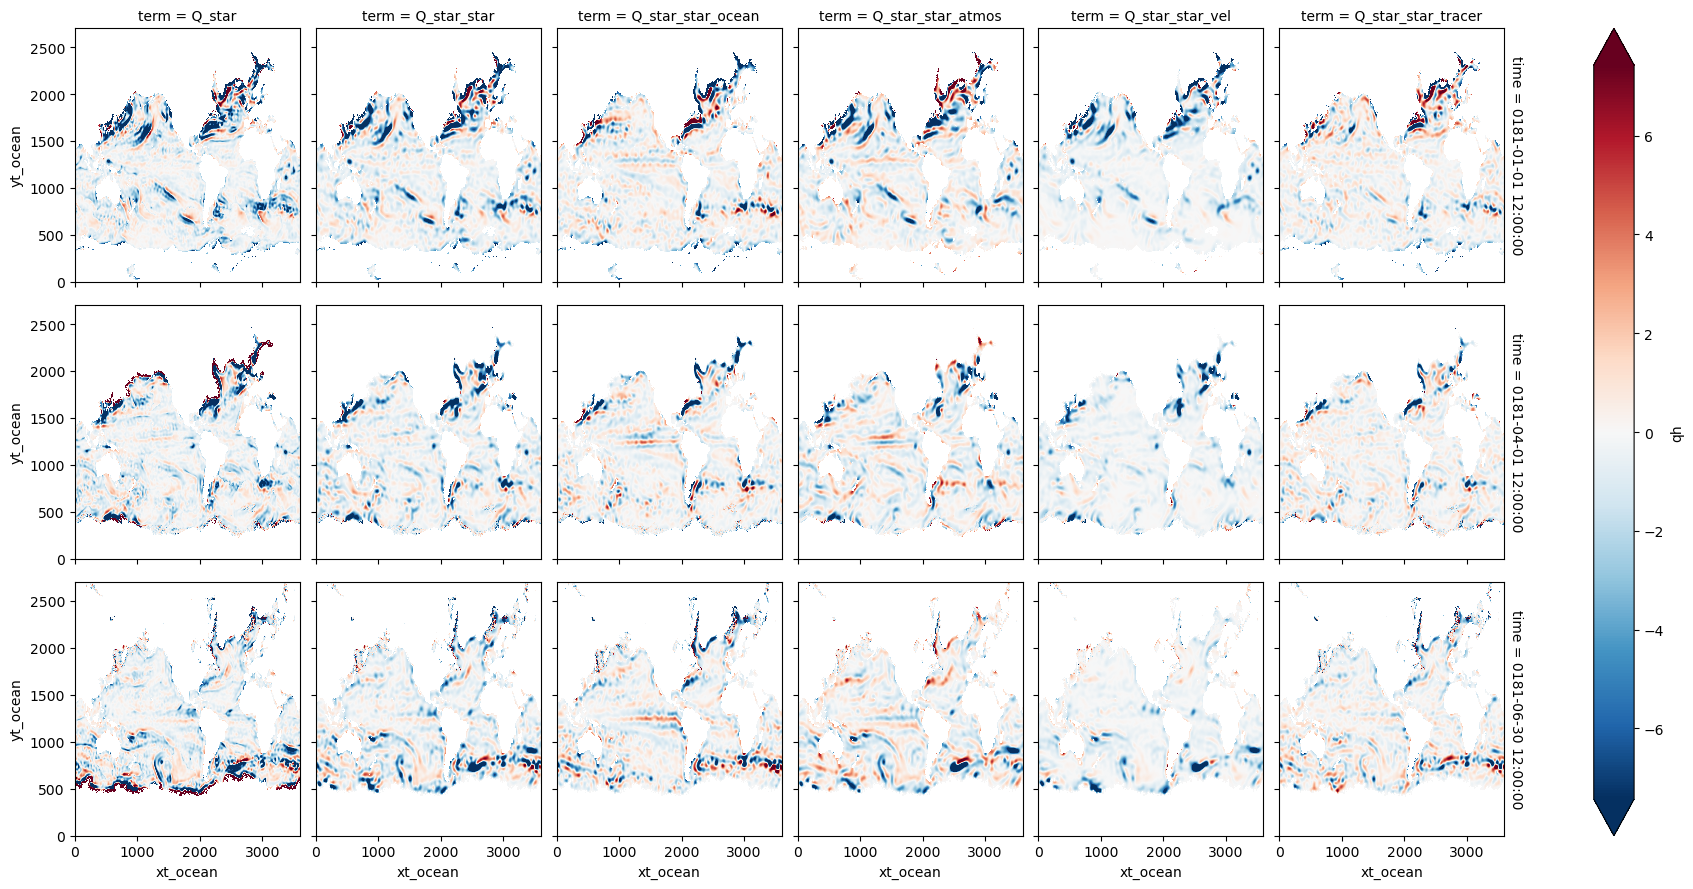

<Figure size 640x480 with 0 Axes>

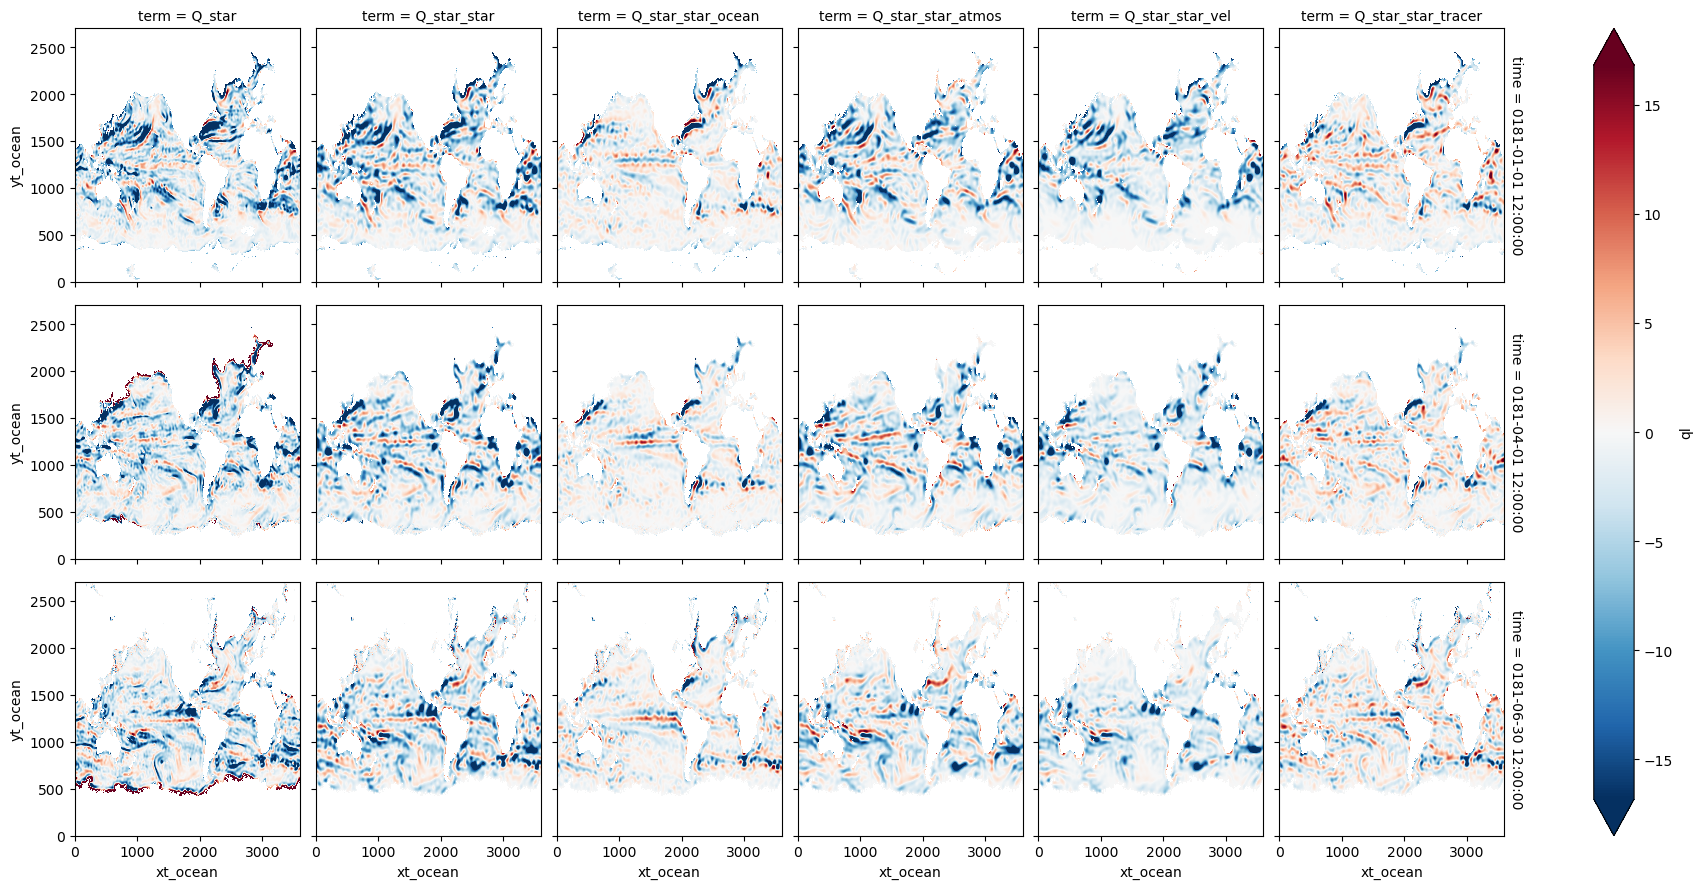

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_coarse_decomposed_mean_prod_50.zarr


<xarray.Dataset>
Dimensions:   (algo: 1, yt_ocean: 54, xt_ocean: 72, term: 1)
Coordinates:
  * algo      (algo) int64 0
    area_t    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * term      (term) <U11 'Q_star_star'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(1, 54, 72, 1), meta=np.ndarray>
    ql        (term, yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(1, 54, 72, 1), meta=np.ndarray>
Attributes:
    model:             CM26
    n_coarsen:         50
    production_spec:   prod
    smoothing_method:  coarse
    time_spec:         prod

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

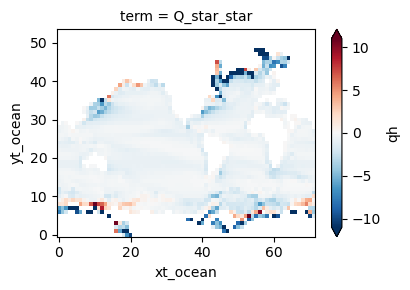

<Figure size 640x480 with 0 Axes>

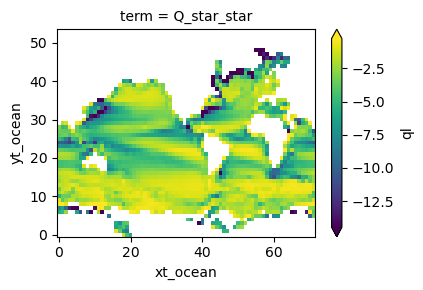

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CESM_fluxes_coarse_decomposed_mean_prod_50.zarr


<xarray.Dataset>
Dimensions:   (algo: 1, yt_ocean: 48, xt_ocean: 72, term: 1)
Coordinates:
  * algo      (algo) int64 0
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
  * term      (term) <U11 'Q_star_star'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 48, 72, 1), meta=np.ndarray>
    ql        (term, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 48, 72, 1), meta=np.ndarray>
Attributes:
    model:             CESM
    n_coarsen:         50
    production_spec:   prod
    smoothing_method:  coarse
    time_spec:         prod

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

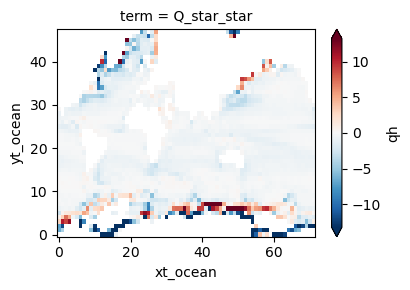

<Figure size 640x480 with 0 Axes>

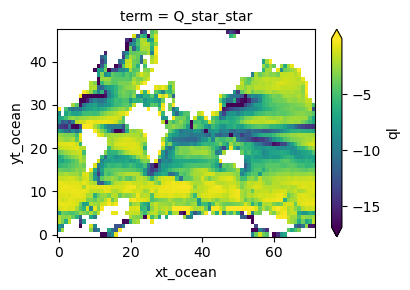

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_coarse_decomposed_mean_appendix_50.zarr


<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 54, xt_ocean: 72, term: 1)
Coordinates:
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(54, 72, 5), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * term      (term) <U11 'Q_star_star'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 51, 51), meta=np.ndarray>
    ql        (term, algo, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 51, 51), meta=np.ndarray>
Attributes:
    model:             CM26
    n_coarsen:         50
    production_spec:   appendix
    smoothing_method:  coarse
    time_spec:         appendix

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

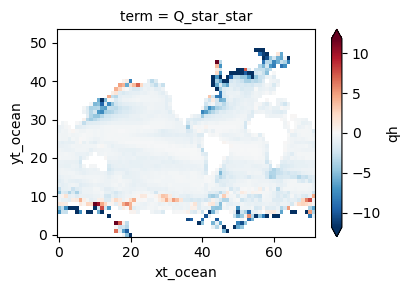

<Figure size 640x480 with 0 Axes>

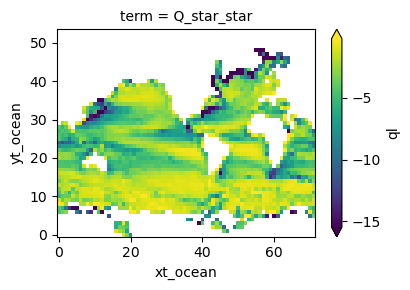

Reloading data from gs://leap-persistent/jbusecke/scale-aware-air-sea/v1.0.1/results/CM26_fluxes_coarse_decomposed_native_appendix_50.zarr


<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 54, xt_ocean: 72, term: 1, time: 365)
Coordinates:
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean, algo) float32 dask.array<chunksize=(54, 72, 5), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * term      (term) <U11 'Q_star_star'
  * time      (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 51, 51), meta=np.ndarray>
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 51, 51), meta=np.ndarray>
Attributes:
    model:             CM26
    n_coarsen:         50
    production_spec:   appendix
    smoothing_method:  coarse
    time_spec:         appendix

Testing reloaded output
smoothing_method
production_spec
model
time_spec


<Figure size 640x480 with 0 Axes>

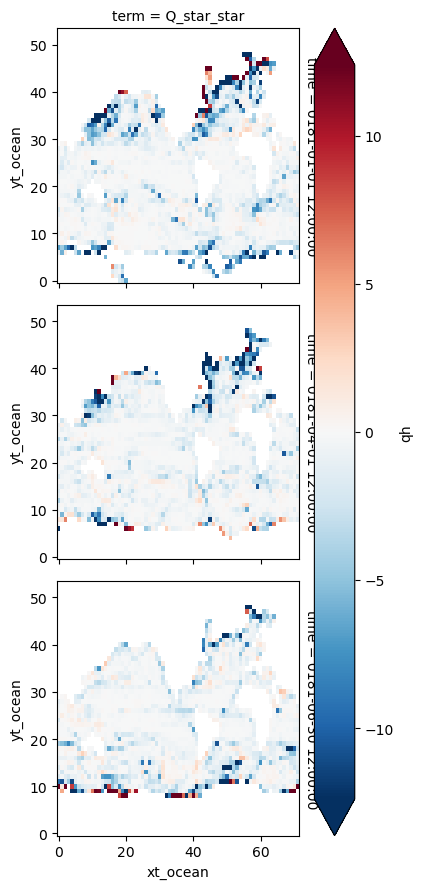

<Figure size 640x480 with 0 Axes>

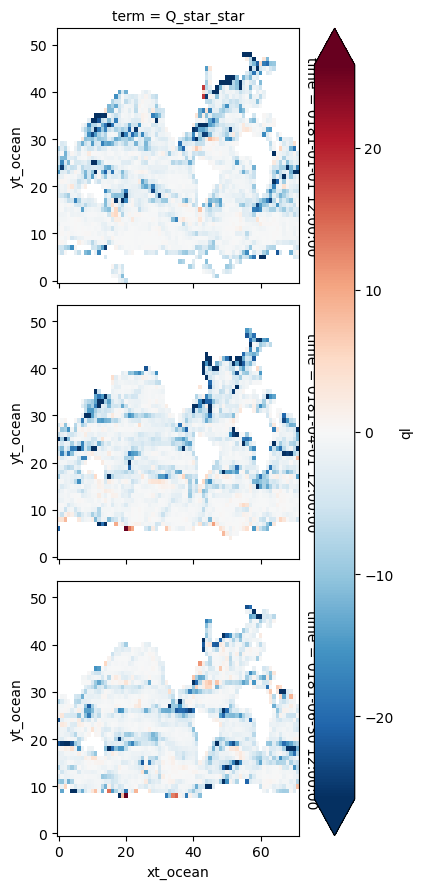

In [33]:
keep_terms = {
    'prod': ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos'],
    'appendix': ['Q_star', 'Q_star_star', 'Q_star_star_ocean','Q_star_star_atmos','Q_star_star_vel', 'Q_star_star_tracer'],
}

result_data = nested_dict()

for smoothing_method, production_spec, model, time_spec in [
    ('filter', 'prod', 'CM26', 'mean'),
    # ('filter', 'prod', 'CM26', 'native'), # This is hella expensive. only do if totally necessary
    ('filter', 'prod', 'CESM', 'mean'), 
    # ('filter', 'prod', 'CESM', 'native'), # This is hella expensive. only do if totally necessary
    ('filter', 'appendix', 'CM26', 'mean'),
    ('filter', 'appendix', 'CM26', 'native'),
    # # ('filter', 'appendix', 'CESM', 'mean'), # this one fails
    # # ('filter', 'appendix', 'CESM', 'native'), # this one fails
    ('coarse', 'prod', 'CM26', 'mean'),
    # ('coarse', 'prod', 'CM26', 'native'), # I could consider writing these if we need them..
    ('coarse', 'prod', 'CESM', 'mean'),
    # ('coarse', 'prod', 'CESM', 'native'), # I could consider writing these if we need them..
    ('coarse', 'appendix', 'CM26', 'mean'),
    ('coarse', 'appendix', 'CM26', 'native'),
    # ('coarse', 'appendix', 'CESM', 'mean'), # cant do this one without the filtered
    # ('coarse', 'appendix', 'CESM', 'native'), # cant do this one without the filtered
]:
    path = params['paths'][model]['results'][smoothing_method][time_spec][production_spec]

    if not fs.exists(path):
        print(f'Did not find {path}. Recomputing output')
        ds_flux = flux_data[smoothing_method][production_spec][model]
        
        print(f"Computing Small Scale Decomposition {model} {smoothing_method} {production_spec} {time_spec}")
    
        if time_spec == 'mean':
            ds_flux = ds_flux.mean('time')
        # elif time_spec == 'native':
        #     # remove some algos and terms. These filtering ops are crazy slow
        #     ds_flux = ds_flux.sel(term=[t for t in ds_flux.term if t not in ['Q_star']])
        #     ds_flux
            
    
        ds_out = small_scale_decomposition(ds_flux)
    
        # reduce the terms for the production output to save space 
        ds_out = ds_out.sel(term=[t for t in keep_terms[production_spec] if t in ds_out.term])
    
        ds_out.attrs['time_spec'] = production_spec
        
        display(ds_out)
        
        print(f"Start Writing to zarr {path} (Size in memory: {ds_out.nbytes/1e12}TB)")
        ds_out.to_zarr(path)

    print(f"Reloading data from {path}")
    ds_reloaded = xr.open_dataset(path, engine='zarr', chunks={})
    display(ds_reloaded)
    
    print(f"Testing reloaded output")
    test_data_results(ds_reloaded, full_check=full_check, plot=True)

    result_data[smoothing_method][production_spec][time_spec][model] = ds_reloaded

## Notes
- the flux compute for the long runs still overloads memory. Might just have to get more memory on the workers...or inline_array?